In [33]:
%cd /content/drive/MyDrive/입찰/range

/content/drive/MyDrive/입찰/range


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, concatenate, GRU
from keras import optimizers
from tensorflow.keras.utils import to_categorical

In [35]:
data = np.loadtxt('./data.csv', delimiter=',')#########파일 넣는 곳################
data = data.reshape(-1,1)
#data = data[-2000:]

train_raw = data[:int(len(data)*0.9)] # train
test_raw = data[-(len(data)-len(train_raw)):] # test
train_raw += 10
test_raw += 10

In [36]:
def datamake(data):
  ndata = []
  c = 3
  for i in range(len(data)-1):
    ndata.append(data[i])
    sum = data[i] + data[i+1]
    mean = sum / 2
    for j in range(c):
      if j==0:
        mean2 = (mean+data[i]) / 2
      elif j==1:
        mean2 = mean
      elif j==2:
        mean2 = (mean+data[i+1]) / 2
      ndata.append(mean2)
  ndata.append(data[-1])
  ndata = np.array(ndata)
  return ndata

In [37]:
train_added = datamake(train_raw)
test_added = datamake(test_raw)
print('train_data : ', train_added.shape)
print('test_data : ', test_added.shape)

train_data :  (9769, 1)
test_data :  (1085, 1)


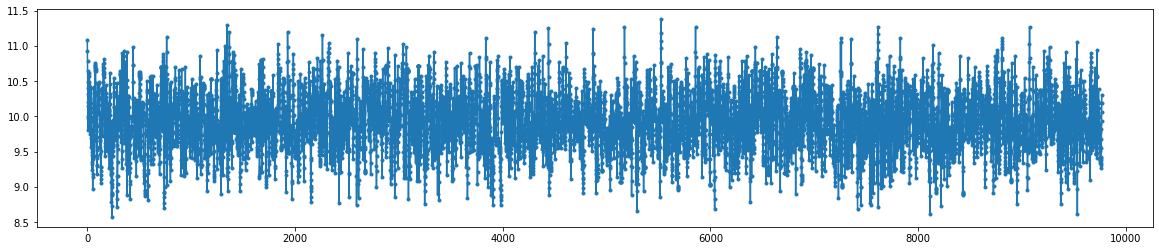

In [38]:
plt.figure(figsize=[20,4])
plt.plot(train_added,'.-')

In [50]:
length = 1 ###################################
seq_length = length * 4

In [51]:
def make_data(train):
    X_train = [] 
    Y_train = []
    for i in range(length, train.shape[0]):
        X_train.append(train[i-length:i, 0])
        Y_train.append(train[i, 0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    return X_train, Y_train

In [52]:
def make_data_added(train):
    X_train = [] 
    Y_train = []
    for i in range(seq_length, train.shape[0]+1, 4):
        X_train.append(train[i-seq_length:i, 0])
        Y_train.append(train[i, 0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    return X_train, Y_train

In [53]:
def make_class(Y):
  df = pd.DataFrame(Y)
  df.columns = ['Data']
  df["label"] = np.nan
  i=0
  for x in range(8):
    start = 8.5 + x*0.25
    end = 8.5 + 0.25*(x+1)
    temp = df[(df["Data"] >= start) & (df["Data"] < end)]
    df['label'].iloc[temp.index] = i
    i+=1
  df = df.fillna(8)
  return df

In [54]:
# train_raw, test_raw, train_added, test_added, train_added_scaled, test_added_scaled
_, Y_train = make_data(train_raw)
X_train, _ = make_data_added(train_added)

_, Y_test = make_data(test_raw)
X_test, _ = make_data_added(test_added)

label = make_class(Y_train)
label = list(np.array(label['label'].tolist()))
one_hot = to_categorical(label)

classes = make_class(Y_test)
classes = list(np.array(classes['label'].tolist()))
two_hot = to_categorical(classes)

In [56]:
inputs = Input(shape = (seq_length, 1))
x = LSTM(32, return_sequences=True)(inputs)
x = Dropout(0.5)(x)
x = LSTM(64, return_sequences=True)(x)
x = Dropout(0.5)(x)

y = LSTM(64, return_sequences=True)(inputs)
y = Dropout(0.5)(y)
y = LSTM(128, return_sequences=True)(y)
y = Dropout(0.5)(y)

z = LSTM(128, return_sequences=True)(inputs)
z = Dropout(0.5)(z)
z = LSTM(256, return_sequences=True)(z)
z = Dropout(0.5)(z)

concat = concatenate([x, y, z])
output = LSTM(256 ,return_sequences=False)(concat)
output = Dropout(0.5)(output)
outputs = Dense(9, activation = 'softmax')(output)

model = Model(inputs = inputs, outputs = outputs)

In [57]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, one_hot, epochs = 300, batch_size = 50, validation_split=0.1)

Epoch 1/300
44/44 [==============================] - 10s 53ms/step - loss: 2.0229 - accuracy: 0.1953 - val_loss: 1.9780 - val_accuracy: 0.1347
Epoch 2/300
44/44 [==============================] - 0s 11ms/step - loss: 2.0008 - accuracy: 0.1802 - val_loss: 1.9779 - val_accuracy: 0.2041
Epoch 3/300
44/44 [==============================] - 0s 11ms/step - loss: 1.9971 - accuracy: 0.1957 - val_loss: 1.9779 - val_accuracy: 0.2041
Epoch 4/300
44/44 [==============================] - 0s 11ms/step - loss: 1.9964 - accuracy: 0.1775 - val_loss: 1.9732 - val_accuracy: 0.2041
Epoch 5/300
44/44 [==============================] - 0s 11ms/step - loss: 1.9962 - accuracy: 0.1857 - val_loss: 1.9649 - val_accuracy: 0.2041
Epoch 6/300
44/44 [==============================] - 0s 11ms/step - loss: 1.9923 - accuracy: 0.1980 - val_loss: 1.9674 - val_accuracy: 0.2041
Epoch 7/300
44/44 [==============================] - 0s 11ms/step - loss: 1.9908 - accuracy: 0.1816 - val_loss: 1.9723 - val_accuracy: 0.2041
Epoch

In [58]:
model.evaluate(X_test, two_hot)

9/9 [==============================] - 0s 5ms/step - loss: 0.1997 - accuracy: 0.9336


[0.19968554377555847, 0.9335793256759644]

In [32]:
dummy = np.array([])
#dummy = np.append(dummy, data[-1])
dummy = np.append(dummy, ) #################################################
dummy = np.append(dummy, ) #################################################
dummy = dummy.reshape(1,2,1)
result = model.predict(dummy)
print(np.argmax(result))

0
